Epoch 1/20
1852/1875 [============================>.] - ETA: 0s - loss: 50.4540 - accuracy: 0.8664
Epoch 1: Average scale value: 0.14633511006832123, Loss: 50.277767181396484, Accuracy: 0.8667833209037781

1875/1875 [==============================] - 3s 2ms/step - loss: 50.2778 - accuracy: 0.8668 - val_loss: 35.9141 - val_accuracy: 0.9113
Epoch 2/20
1865/1875 [============================>.] - ETA: 0s - loss: 29.6611 - accuracy: 0.9254
Epoch 2: Average scale value: 0.2313116043806076, Loss: 29.634645462036133, Accuracy: 0.9252833127975464

1875/1875 [==============================] - 3s 1ms/step - loss: 29.6346 - accuracy: 0.9253 - val_loss: 24.6459 - val_accuracy: 0.9353
Epoch 3/20
1850/1875 [============================>.] - ETA: 0s - loss: 21.2205 - accuracy: 0.9393
Epoch 3: Average scale value: 0.32541391253471375, Loss: 21.181087493896484, Accuracy: 0.9392499923706055

1875/1875 [==============================] - 3s 1ms/step - loss: 21.1811 - accuracy: 0.9392 - val_loss: 18.2019 -

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_18537/3659487769.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


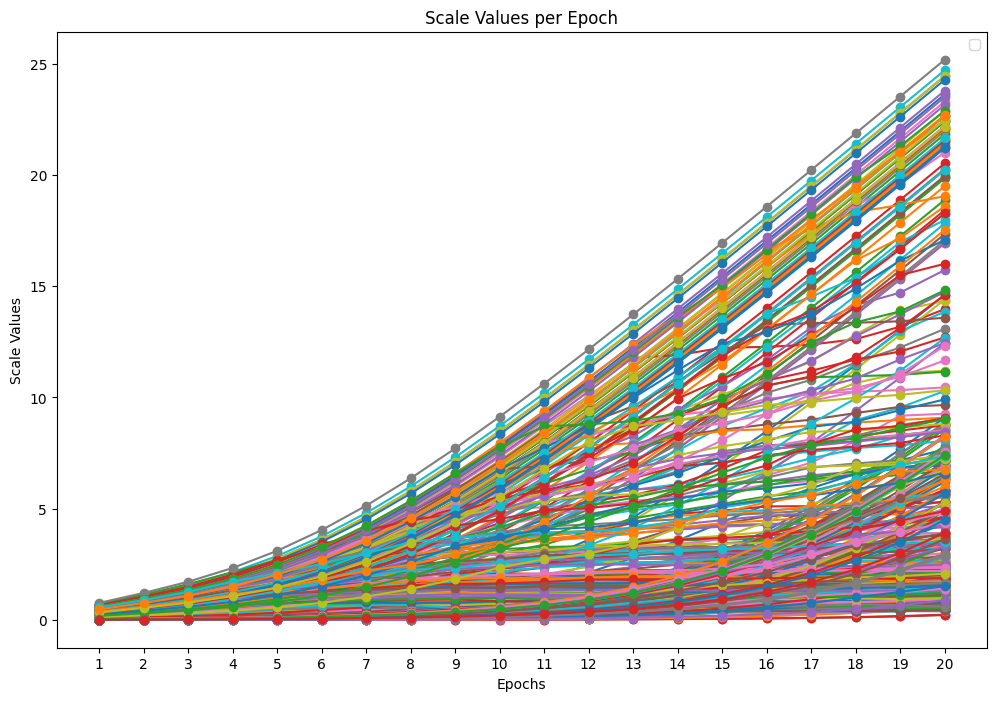

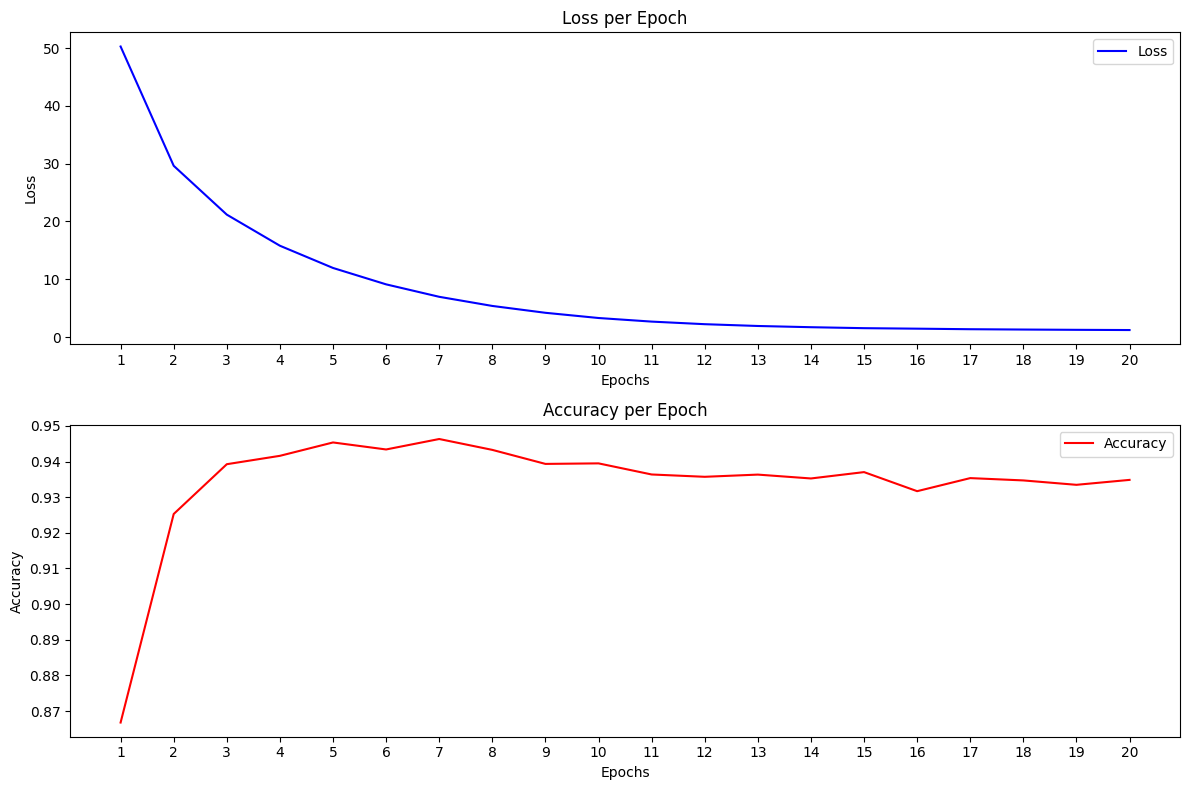

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        # w = 5
        # scale = 2
        # w/scale = 2.5
        # Forward pass -> 2 + (2.5 - 2.5) = 2
        # Backpropagation -> 0 + (2.5 - 0) = 2.5    

        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale)) + \
                      (self.w / self.scale - tf.stop_gradient(self.w / self.scale))
        dequantized_w = quantized_w * self.scale

        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0])) + \
                      (self.b / self.scale[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0]))
        dequantized_b = quantized_b * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b

        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: Average scale value: {average_scale_value}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}\n")

    def plot_scale_values(self):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch]
            plt.plot(range(1, len(self.scale_values_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()

        plt.tight_layout()
        plt.show()

def custom_loss(y_true, y_pred, scale):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    scale_penalty = tf.reduce_mean(1.0 / (scale + 1e-6))  # Add a small epsilon to avoid division by zero
    return cross_entropy_loss + 1 * scale_penalty  # Adjust the regularization weight as needed

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, quantized_dense_layer.scale),
    metrics=['accuracy']
)

average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[average_scale_tracking_callback]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the scale values
average_scale_tracking_callback.plot_scale_values()
average_scale_tracking_callback.plot_loss_accuracy()


In [85]:
eps_float32 = np.finfo(np.float32).eps
print(f'Machine epsilon for float32: {eps_float32}')


Machine epsilon for float32: 1.1920928955078125e-07


## LOSS: Mean of the inverse of the scale values plus epsilon

Epoch 1/20
1863/1875 [============================>.] - ETA: 0s - loss: 150.8874 - accuracy: 0.8473
Epoch 1: Average scale value: 0.19761715829372406, Loss: 150.62017822265625, Accuracy: 0.8476499915122986

Epoch 1: Average scale value: 0.15509770810604095, Loss: 150.62017822265625, Accuracy: 0.8476499915122986
1875/1875 [==============================] - 4s 2ms/step - loss: 150.6202 - accuracy: 0.8476 - val_loss: 108.9256 - val_accuracy: 0.9073
Epoch 2/20
1858/1875 [============================>.] - ETA: 0s - loss: 90.5234 - accuracy: 0.9028
Epoch 2: Average scale value: 0.31646043062210083, Loss: 90.38866424560547, Accuracy: 0.9028833508491516

Epoch 2: Average scale value: 0.24258314073085785, Loss: 90.38866424560547, Accuracy: 0.9028833508491516
1875/1875 [==============================] - 3s 2ms/step - loss: 90.3887 - accuracy: 0.9029 - val_loss: 75.5841 - val_accuracy: 0.9180
Epoch 3/20
1848/1875 [============================>.] - ETA: 0s - loss: 65.3474 - accuracy: 0.9150
Epoch 

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_18537/3450423894.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


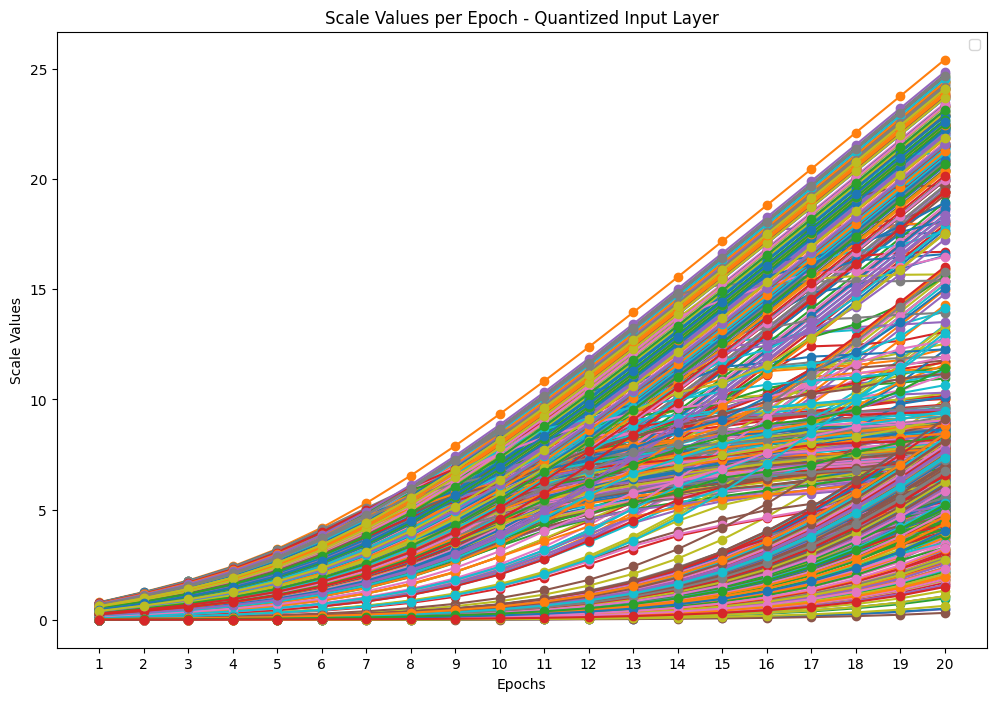

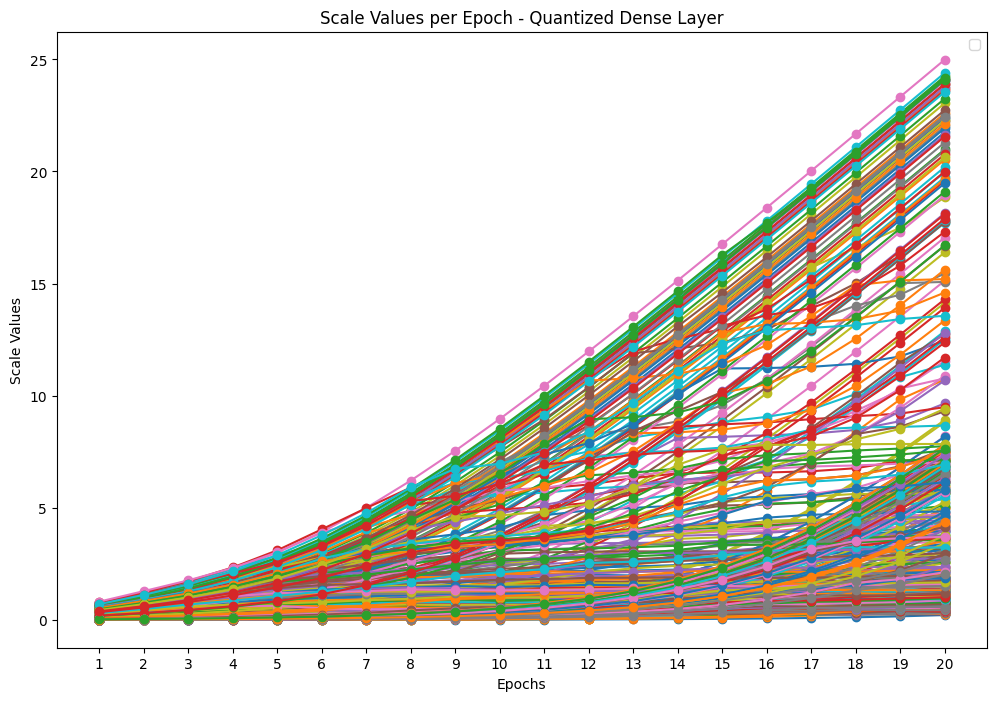

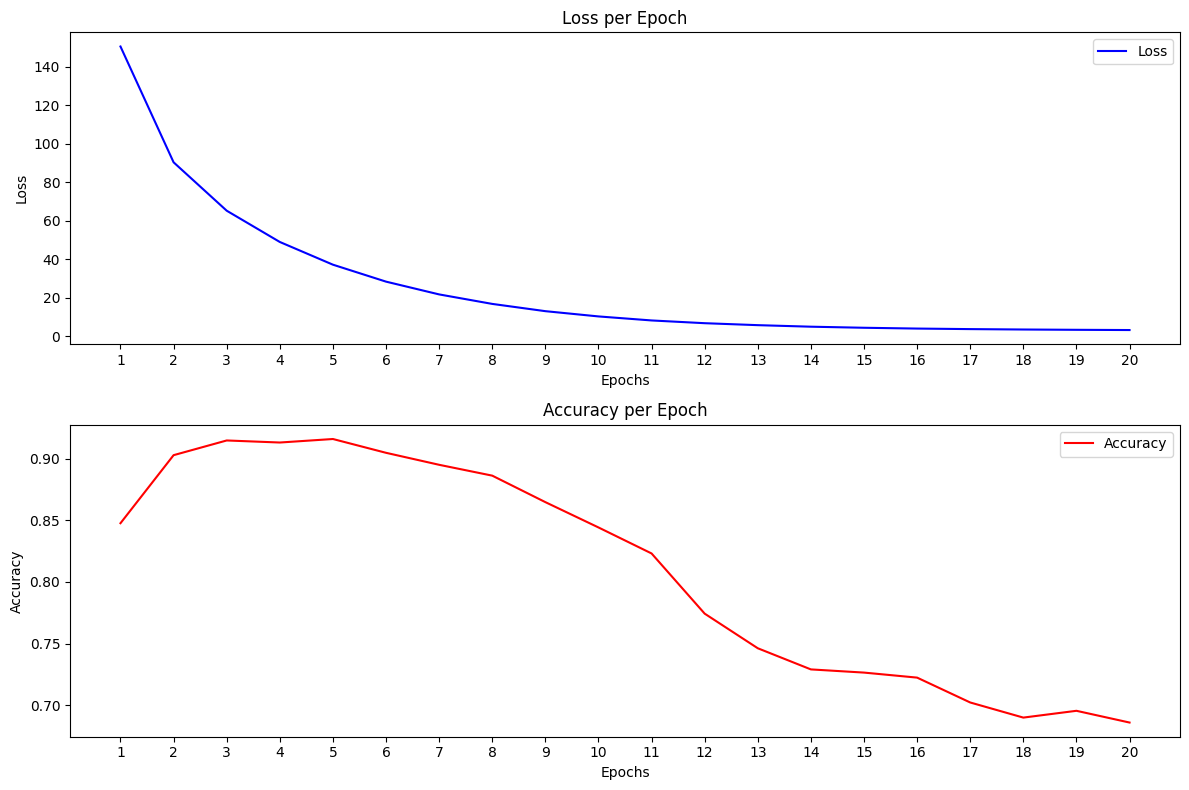

In [87]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: Average scale value: {average_scale_value}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}")

    def plot_scale_values(self, layer_name):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch]
            plt.plot(range(1, len(self.scale_values_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.tight_layout()
        plt.show()

class LearnedQuantizedInput(tf.keras.layers.Layer):
    def __init__(self):
        super(LearnedQuantizedInput, self).__init__()

    def build(self, input_shape):
        self.scale = self.add_weight(shape=(input_shape[1], input_shape[2], input_shape[3]), 
                                     initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_inputs = tf.stop_gradient(tf.round(inputs / self.scale)) + \
                           (inputs / self.scale - tf.stop_gradient(inputs / self.scale))
        dequantized_inputs = quantized_inputs * self.scale
        return dequantized_inputs

    def get_scale(self):
        return self.scale

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale)) + \
                      (self.w / self.scale - tf.stop_gradient(self.w / self.scale))
        dequantized_w = quantized_w * self.scale

        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0])) + \
                      (self.b / self.scale[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0]))
        dequantized_b = quantized_b * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b

        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_scale(self):
        return self.scale

def custom_loss(y_true, y_pred, scales_of_layers):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    # small epsilon to avoid division by zero
    epsilon = eps_float32
    scale_penalty = 0
    penalty_rate = 1
    for scales_of_layer in scales_of_layers:
        # penalty = mean of the inverse of the scale values plus epsilon
        scale_penalty += tf.reduce_mean(1.0 / (scales_of_layer + epsilon))
    
    # Combine the cross-entropy loss and the scale penalty
    total_loss = cross_entropy_loss + penalty_rate * scale_penalty
    
    return total_loss

input_layer = Input(shape=(28, 28, 1))
quantized_input_layer = LearnedQuantizedInput()(input_layer)
flatten_layer = Flatten()(quantized_input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)

quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 
                                            [quantized_model.get_layer(index=1).get_scale(), 
                                             quantized_model.get_layer(index=3).get_scale(),
                                             quantized_model.get_layer(index=4).get_scale()]),
    metrics=['accuracy']
)

scale_tracking_callback_input_layer = ScaleTrackingCallback(quantized_model.get_layer(index=1))
scale_tracking_callback_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=3))

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[scale_tracking_callback_input_layer,
               scale_tracking_callback_dense_layer]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Print layer details
#for i, layer in enumerate(quantized_model.layers):
#    print(f"\nLAYER {i}: {layer}")
#    print(f"  - Input Shape: {layer.input_shape}")
#    print(f"  - Output Shape: {layer.output_shape}")
#    if hasattr(layer, 'get_scale'):
#        print(f"  - Scale Shape: {layer.get_scale().shape}")


scale_tracking_callback_input_layer.plot_scale_values(layer_name="Quantized Input Layer")
scale_tracking_callback_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer")
scale_tracking_callback_dense_layer.plot_loss_accuracy()



## LOSS: Mean of the inverse of the scale values plus epsilon (penalty rate 0.1)

Epoch 1/20
1866/1875 [============================>.] - ETA: 0s - loss: 2.3925 - accuracy: 0.8526
Epoch 1: Average scale value: 0.21338112652301788, Loss: 2.4319980144500732, Accuracy: 0.8525999784469604

Epoch 1: Average scale value: 0.1106380894780159, Loss: 2.4319980144500732, Accuracy: 0.8525999784469604
1875/1875 [==============================] - 4s 2ms/step - loss: 2.4320 - accuracy: 0.8526 - val_loss: 10.6088 - val_accuracy: 0.8654
Epoch 2/20
1864/1875 [============================>.] - ETA: 0s - loss: 8.8348 - accuracy: 0.8893
Epoch 2: Average scale value: 0.34162357449531555, Loss: 8.82617473602295, Accuracy: 0.8894666433334351

Epoch 2: Average scale value: 0.1678396761417389, Loss: 8.82617473602295, Accuracy: 0.8894666433334351
1875/1875 [==============================] - 3s 2ms/step - loss: 8.8262 - accuracy: 0.8895 - val_loss: 7.4598 - val_accuracy: 0.8958
Epoch 3/20
1874/1875 [============================>.] - ETA: 0s - loss: 6.4384 - accuracy: 0.9039
Epoch 3: Average sc

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_18537/3520506345.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


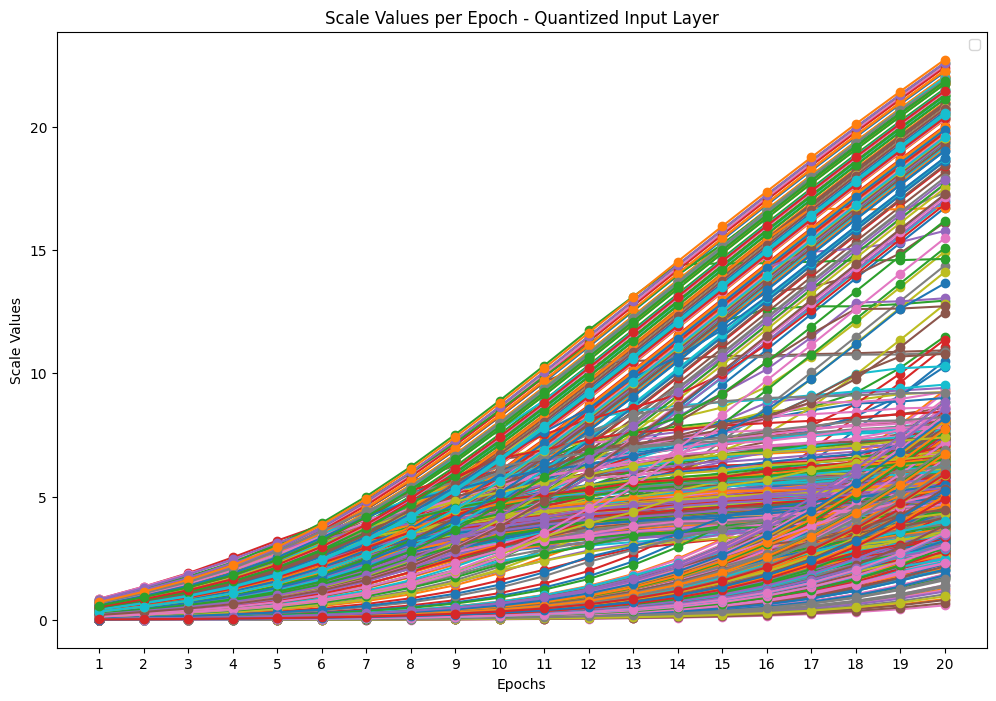

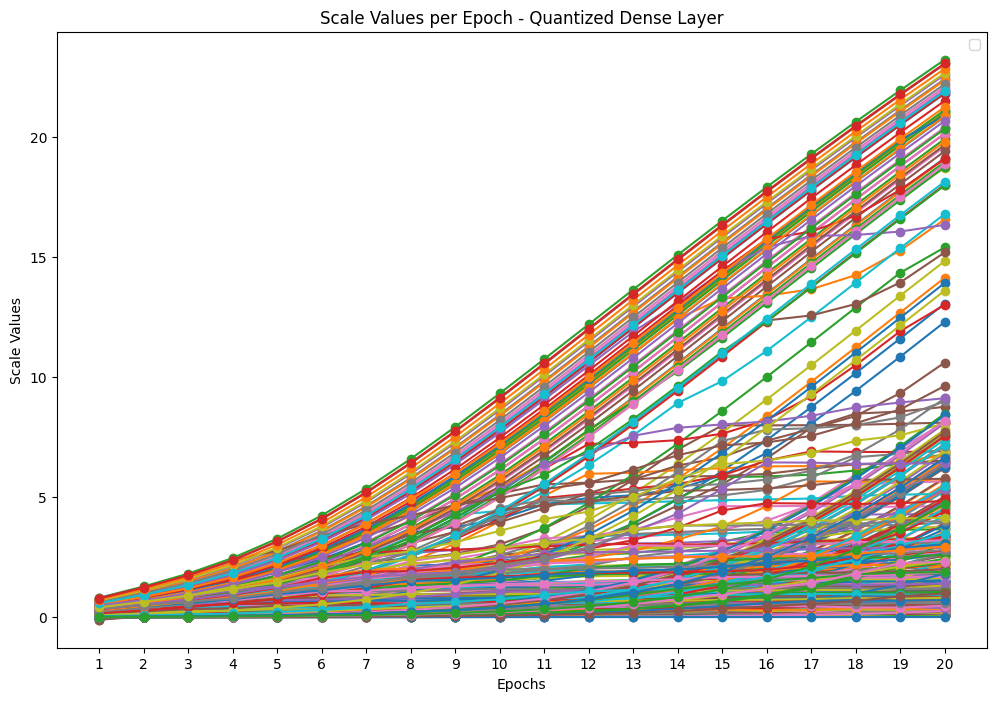

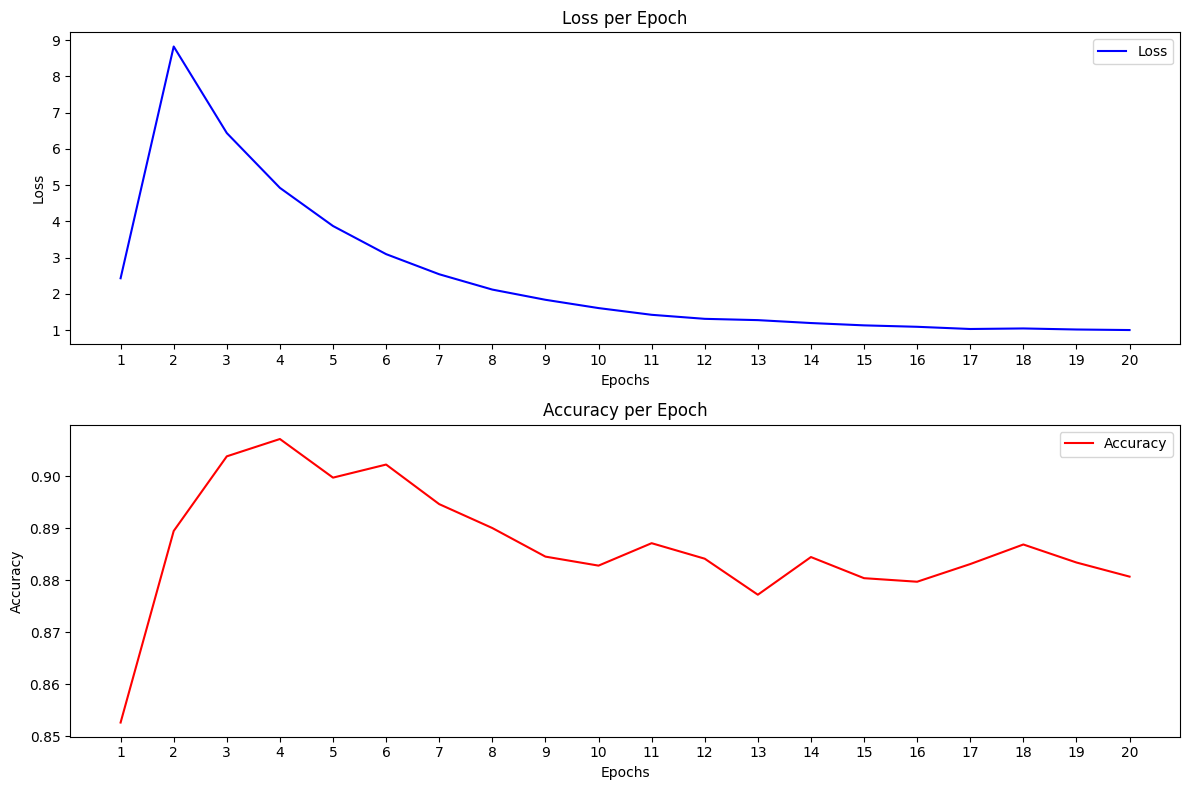

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: Average scale value: {average_scale_value}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}")

    def plot_scale_values(self, layer_name):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch]
            plt.plot(range(1, len(self.scale_values_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.tight_layout()
        plt.show()

class LearnedQuantizedInput(tf.keras.layers.Layer):
    def __init__(self):
        super(LearnedQuantizedInput, self).__init__()

    def build(self, input_shape):
        self.scale = self.add_weight(shape=(input_shape[1], input_shape[2], input_shape[3]), 
                                     initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_inputs = tf.stop_gradient(tf.round(inputs / self.scale)) + \
                           (inputs / self.scale - tf.stop_gradient(inputs / self.scale))
        dequantized_inputs = quantized_inputs * self.scale
        return dequantized_inputs

    def get_scale(self):
        return self.scale

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale)) + \
                      (self.w / self.scale - tf.stop_gradient(self.w / self.scale))
        dequantized_w = quantized_w * self.scale

        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0])) + \
                      (self.b / self.scale[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0]))
        dequantized_b = quantized_b * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b

        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_scale(self):
        return self.scale

def custom_loss(y_true, y_pred, scales_of_layers):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    # small epsilon to avoid division by zero
    epsilon = eps_float32
    scale_penalty = 0
    penalty_rate = 0.1
    for scales_of_layer in scales_of_layers:
        # penalty = mean of the inverse of the scale values plus epsilon
        scale_penalty += tf.reduce_mean(1.0 / (scales_of_layer + epsilon))
    
    # Combine the cross-entropy loss and the scale penalty
    total_loss = cross_entropy_loss + penalty_rate * scale_penalty
    
    return total_loss

input_layer = Input(shape=(28, 28, 1))
quantized_input_layer = LearnedQuantizedInput()(input_layer)
flatten_layer = Flatten()(quantized_input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)

quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 
                                            [quantized_model.get_layer(index=1).get_scale(), 
                                             quantized_model.get_layer(index=3).get_scale(),
                                             quantized_model.get_layer(index=4).get_scale()]),
    metrics=['accuracy']
)

scale_tracking_callback_input_layer = ScaleTrackingCallback(quantized_model.get_layer(index=1))
scale_tracking_callback_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=3))

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[scale_tracking_callback_input_layer,
               scale_tracking_callback_dense_layer]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Print layer details
#for i, layer in enumerate(quantized_model.layers):
#    print(f"\nLAYER {i}: {layer}")
#    print(f"  - Input Shape: {layer.input_shape}")
#    print(f"  - Output Shape: {layer.output_shape}")
#    if hasattr(layer, 'get_scale'):
#        print(f"  - Scale Shape: {layer.get_scale().shape}")


scale_tracking_callback_input_layer.plot_scale_values(layer_name="Quantized Input Layer")
scale_tracking_callback_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer")
scale_tracking_callback_dense_layer.plot_loss_accuracy()



## LOSS: Mean of the inverse of the scale values plus epsilon (penalty rate 0.1) with tf.floor

Epoch 1/20
1846/1875 [============================>.] - ETA: 0s - loss: 14.2547 - accuracy: 0.7902
Epoch 1: Average scale value: 0.20820146799087524, Loss: 14.205902099609375, Accuracy: 0.7910666465759277

Epoch 1: Average scale value: 0.10678309202194214, Loss: 14.205902099609375, Accuracy: 0.7910666465759277
1875/1875 [==============================] - 4s 2ms/step - loss: 14.2059 - accuracy: 0.7911 - val_loss: 10.9629 - val_accuracy: 0.8751
Epoch 2/20
1847/1875 [============================>.] - ETA: 0s - loss: 9.2234 - accuracy: 0.8808
Epoch 2: Average scale value: 0.33343467116355896, Loss: 9.204211235046387, Accuracy: 0.8805000185966492

Epoch 2: Average scale value: 0.16042853891849518, Loss: 9.204211235046387, Accuracy: 0.8805000185966492
1875/1875 [==============================] - 3s 2ms/step - loss: 9.2042 - accuracy: 0.8805 - val_loss: 7.8562 - val_accuracy: 0.8589
Epoch 3/20
1863/1875 [============================>.] - ETA: 0s - loss: 6.8489 - accuracy: 0.8791
Epoch 3: Aver

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_18537/1925306415.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


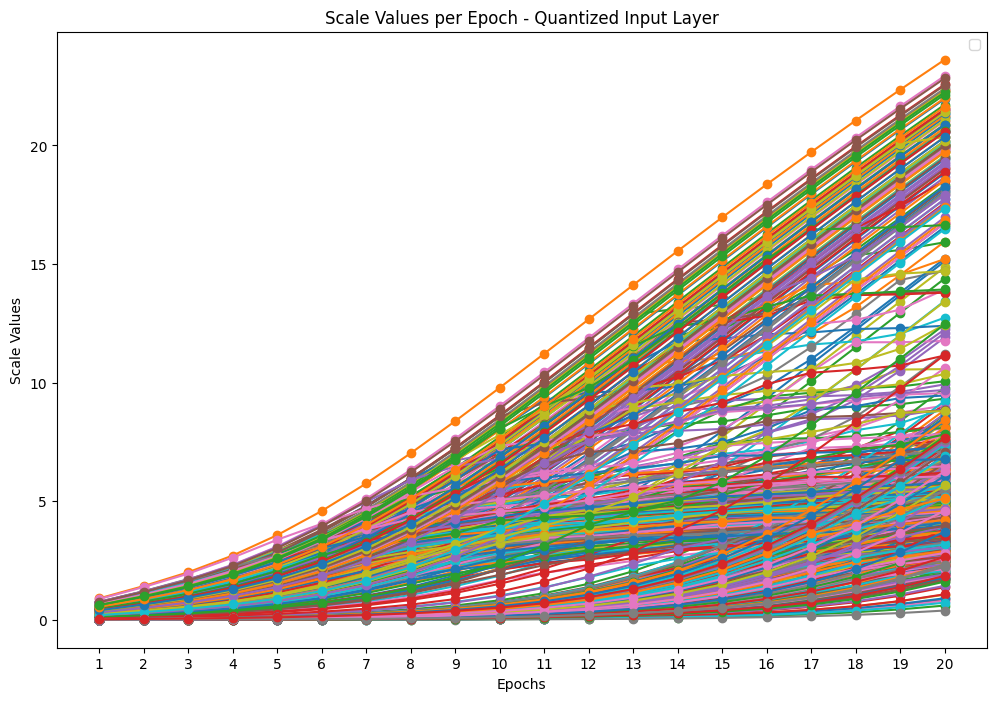

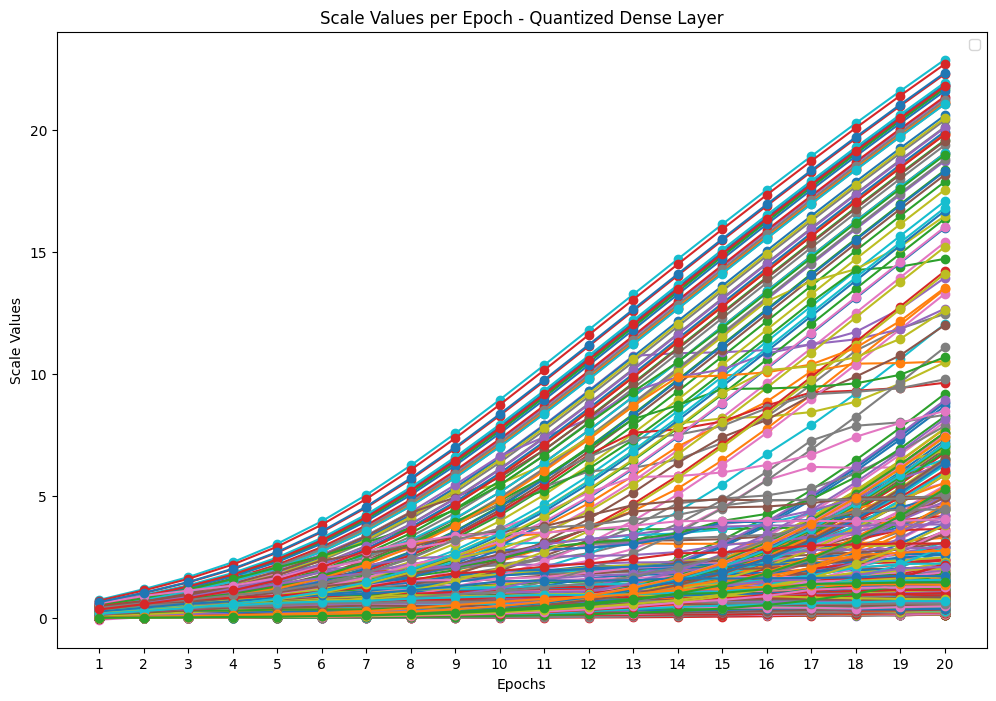

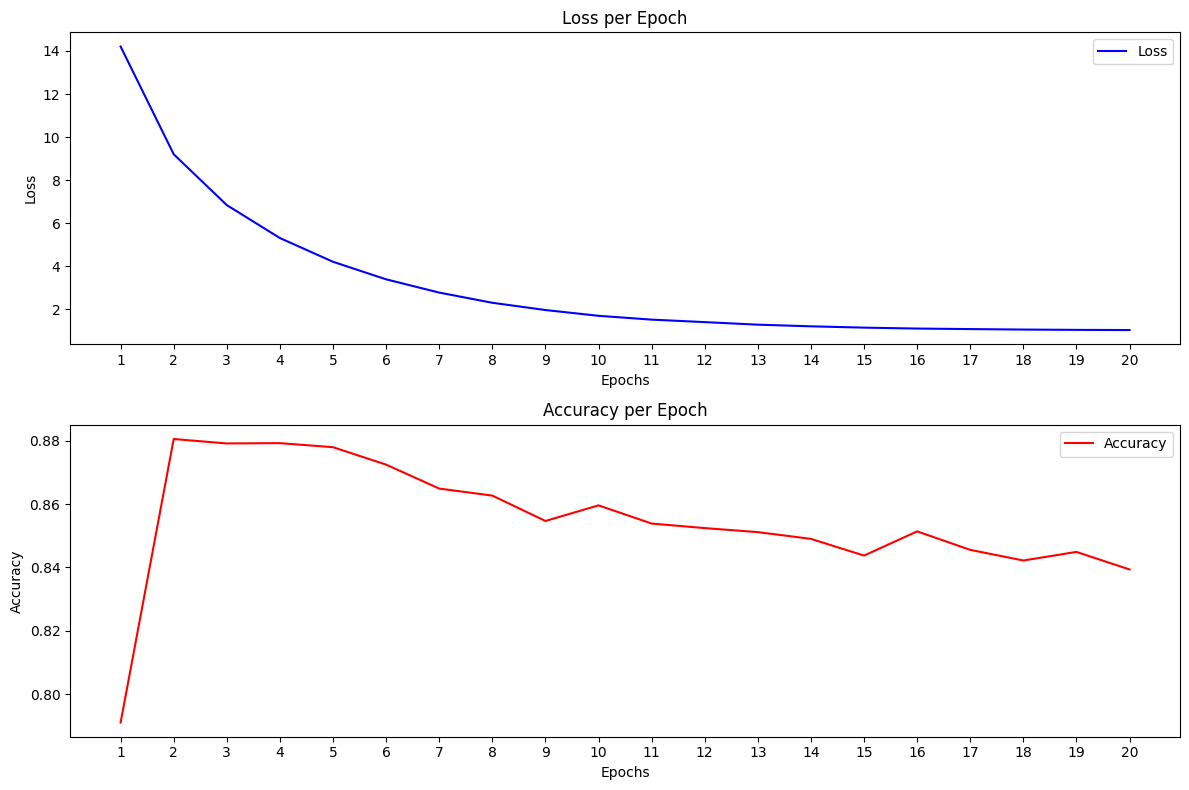

In [95]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: Average scale value: {average_scale_value}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}")

    def plot_scale_values(self, layer_name):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch]
            plt.plot(range(1, len(self.scale_values_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.tight_layout()
        plt.show()

class LearnedQuantizedInput(tf.keras.layers.Layer):
    def __init__(self):
        super(LearnedQuantizedInput, self).__init__()

    def build(self, input_shape):
        self.scale = self.add_weight(shape=(input_shape[1], input_shape[2], input_shape[3]), 
                                     initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_inputs = tf.stop_gradient(tf.floor(inputs / self.scale)) + \
                           (inputs / self.scale - tf.stop_gradient(inputs / self.scale))
        dequantized_inputs = quantized_inputs * self.scale
        return dequantized_inputs

    def get_scale(self):
        return self.scale

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True) 
        # This has the max -> to be used to inform the scaling and how it affects it
        # 16 -> quantize -> 
        # sc
        # take max value / scaling factor => continuous value that represents the number of bins -> do the same for b
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        # w = 5
        # scale = 2
        # ratio 2.5
        # forward = 2 + 2 - 2 = 2
        # backpropagation = 0 + 2.5 - 0 = 2.5
        # are you sure 
        w_ratio_scale = self.w / self.scale
        quantized_w = tf.stop_gradient(tf.floor(w_ratio_scale))
        dequantized_w = quantized_w * self.scale

        b_ratio_scale = self.b / self.scale
        quantized_b = tf.stop_gradient(tf.floor(b_ratio_scale))
#        quantized_b = tf.stop_gradient(tf.floor(self.b / self.scale[0, 0])) + \
#                      (self.b / self.scale[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0]))
        dequantized_b = quantized_b * self.scale[0, 0]  # THIS DOESN'T WORK -> HAve separate scales for b
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b

        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_scale(self):
        return self.scale

def custom_loss(y_true, y_pred, scales_of_layers):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    # small epsilon to avoid division by zero
    epsilon = eps_float32
    scale_penalty = 0
    penalty_rate = 0.1
    for scales_of_layer in scales_of_layers:
        # penalty = mean of the inverse of the scale values plus epsilon
        scale_penalty += tf.reduce_mean(1.0 / (scales_of_layer + epsilon))
    
    # Combine the cross-entropy loss and the scale penalty
    total_loss = cross_entropy_loss + penalty_rate * scale_penalty
#    total_loss = cross_entropy_loss + cross_entropy_loss * penalty_rate * scale_penalty
    # we maintain the independent loss -> but not 100%
    # we need to introduce the term that represents the maximum value of scale values -> if scale becomer larger thatn 256 -> this should be the max value
    # take the max value for the input values before quantization and that would the upper bound
    # lower bound -> half of the maximum -> 2 bins 

    # Handle the situations where the scale is exp. large -> 
    # 
    
    return total_loss

input_layer = Input(shape=(28, 28, 1))
quantized_input_layer = LearnedQuantizedInput()(input_layer)
flatten_layer = Flatten()(quantized_input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)

quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    # modify this so that it passes the scaling loss to the loss function, so that the inverse will not be needed at all.
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 
                                            [quantized_model.get_layer(index=1).get_scale(), 
                                             quantized_model.get_layer(index=3).get_scale(),
                                             quantized_model.get_layer(index=4).get_scale()]),
    metrics=['accuracy']
)

scale_tracking_callback_input_layer = ScaleTrackingCallback(quantized_model.get_layer(index=1))
scale_tracking_callback_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=3))

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[scale_tracking_callback_input_layer,
               scale_tracking_callback_dense_layer]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Print layer details
#for i, layer in enumerate(quantized_model.layers):
#    print(f"\nLAYER {i}: {layer}")
#    print(f"  - Input Shape: {layer.input_shape}")
#    print(f"  - Output Shape: {layer.output_shape}")
#    if hasattr(layer, 'get_scale'):
#        print(f"  - Scale Shape: {layer.get_scale().shape}")


# we need to plot the max, mean, of the loss scaling (max value / scaling factor )
# would be nice if the model trains with and without quantization
# weould be interesting if we can separate the quantization layers so that it can be added to different models (like CNNs)
# Cifar-10 - this the data probably we will use
# maybe also RestNet


scale_tracking_callback_input_layer.plot_scale_values(layer_name="Quantized Input Layer")
scale_tracking_callback_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer")
scale_tracking_callback_dense_layer.plot_loss_accuracy()



## LOSS: Mean of the inverse of the scale values plus epsilon (penalty rate 0.1) with tf.floor and L2 for weights

Epoch 1/100
1851/1875 [============================>.] - ETA: 0s - loss: 13.9360 - accuracy: 0.7962
Epoch 1: Average scale value: 0.2135111540555954, Loss: 13.893372535705566, Accuracy: 0.7971333265304565

Epoch 1: Average scale value: 0.11386851221323013, Loss: 13.893372535705566, Accuracy: 0.7971333265304565
1875/1875 [==============================] - 4s 2ms/step - loss: 13.8934 - accuracy: 0.7971 - val_loss: 10.5176 - val_accuracy: 0.8844
Epoch 2/100
1854/1875 [============================>.] - ETA: 0s - loss: 8.7817 - accuracy: 0.8753
Epoch 2: Average scale value: 0.3419570028781891, Loss: 8.765278816223145, Accuracy: 0.8754666447639465

Epoch 2: Average scale value: 0.16824039816856384, Loss: 8.765278816223145, Accuracy: 0.8754666447639465
1875/1875 [==============================] - 3s 2ms/step - loss: 8.7653 - accuracy: 0.8755 - val_loss: 7.3688 - val_accuracy: 0.8792
Epoch 3/100
1854/1875 [============================>.] - ETA: 0s - loss: 6.4834 - accuracy: 0.8754
Epoch 3: Ave

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_18537/2228684043.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


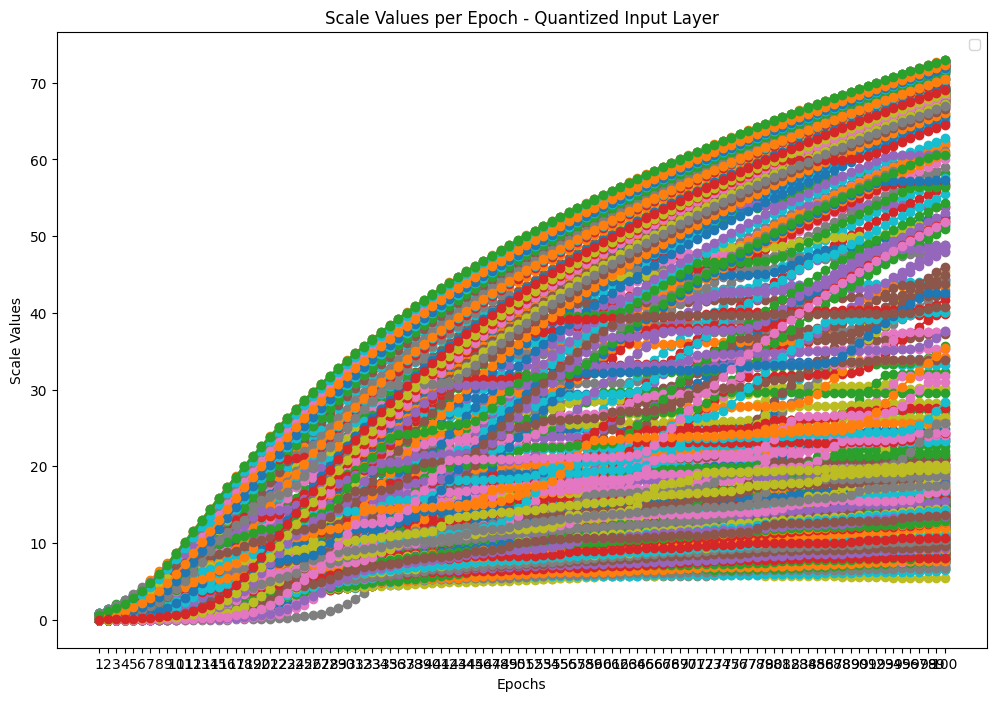

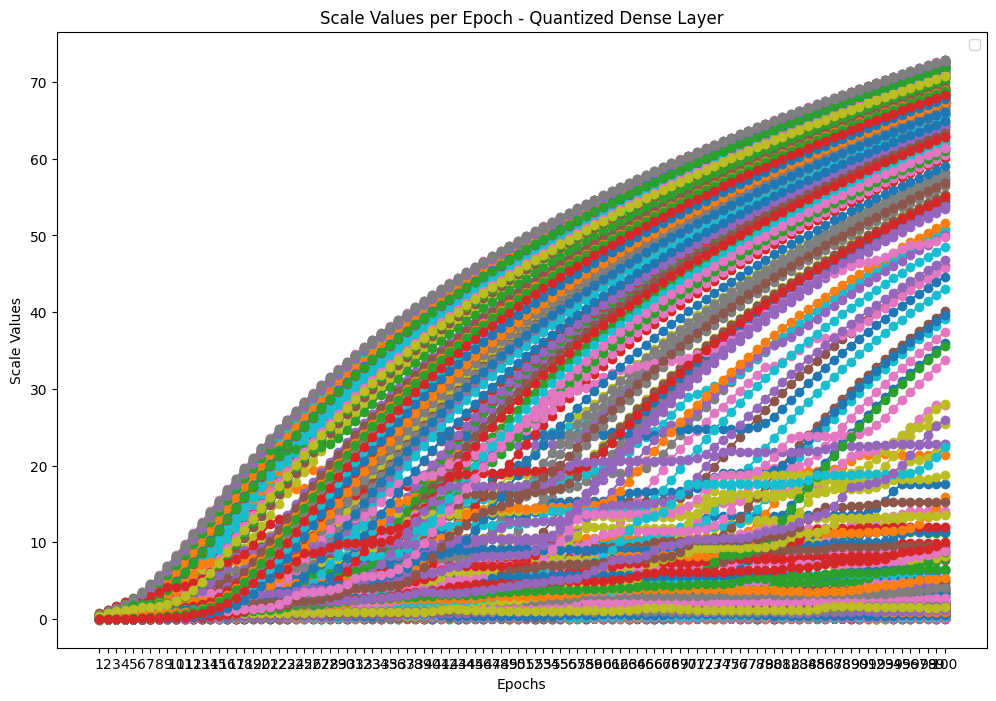

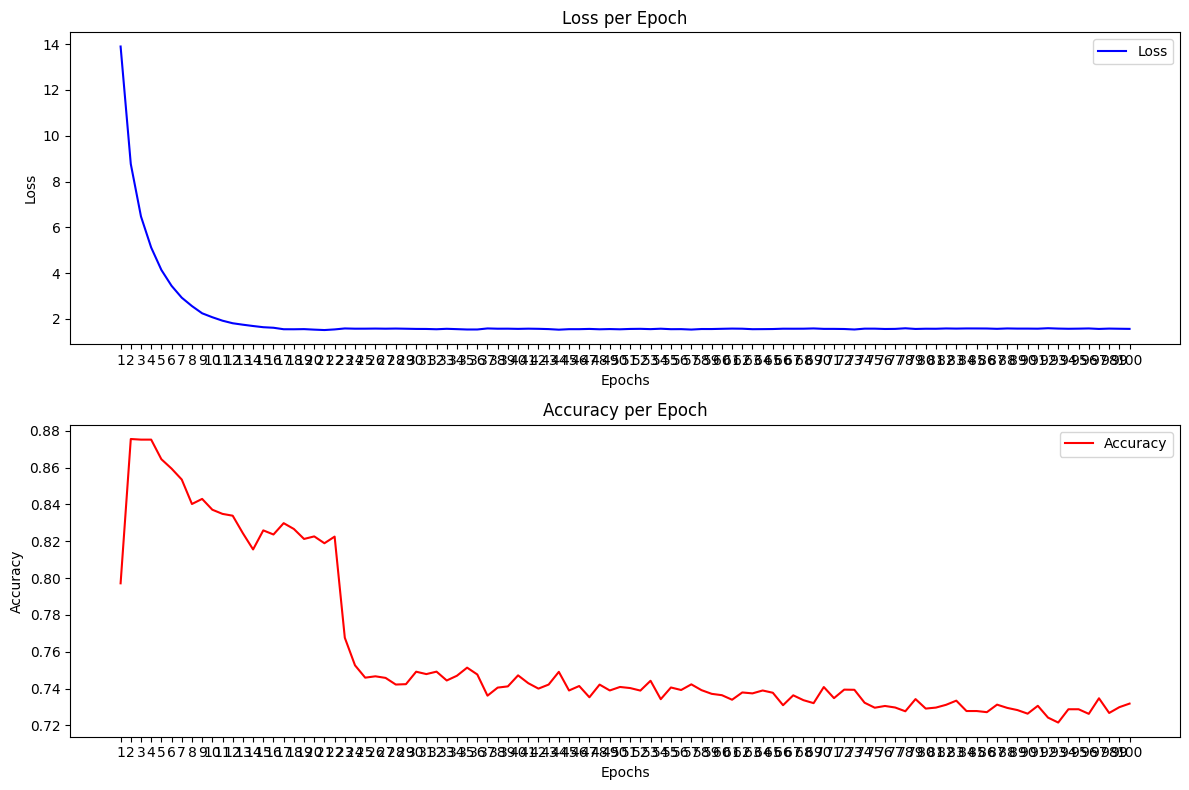

In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: Average scale value: {average_scale_value}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}")

    def plot_scale_values(self, layer_name):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch]
            plt.plot(range(1, len(self.scale_values_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  
        plt.legend()

        plt.tight_layout()
        plt.show()

class LearnedQuantizedInput(tf.keras.layers.Layer):
    def __init__(self):
        super(LearnedQuantizedInput, self).__init__()

    def build(self, input_shape):
        self.scale = self.add_weight(shape=(input_shape[1], input_shape[2], input_shape[3]), 
                                     initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_inputs = tf.stop_gradient(tf.floor(inputs / self.scale)) + \
                           (inputs / self.scale - tf.stop_gradient(inputs / self.scale))
        dequantized_inputs = quantized_inputs * self.scale
        return dequantized_inputs

    def get_scale(self):
        return self.scale

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.floor(self.w / self.scale)) + \
                      (self.w / self.scale - tf.stop_gradient(self.w / self.scale))
        dequantized_w = quantized_w * self.scale

        quantized_b = tf.stop_gradient(tf.floor(self.b / self.scale[0, 0])) + \
                      (self.b / self.scale[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0]))
        dequantized_b = quantized_b * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b

        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_scale(self):
        return self.scale

def custom_loss(y_true, y_pred, scales_of_layers, quantized_model, lambda_l2=0.01):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    # small epsilon to avoid division by zero
    epsilon = 1e-8
    scale_penalty = 0
    penalty_rate = 0.1
    for scales_of_layer in scales_of_layers:
        # penalty = mean of the inverse of the scale values plus epsilon
        scale_penalty += tf.reduce_mean(1.0 / (scales_of_layer + epsilon))

    l2_penalty = 0
    for layer in quantized_model.layers:
        if isinstance(layer, LearnedQuantizedDense):
            l2_penalty += tf.reduce_sum(tf.square(layer.w))

    # Combine the cross-entropy loss, scale penalty, and L2 regularization
    total_loss = cross_entropy_loss + penalty_rate * scale_penalty + lambda_l2 * l2_penalty
    
    return total_loss

input_layer = Input(shape=(28, 28, 1))
quantized_input_layer = LearnedQuantizedInput()(input_layer)
flatten_layer = Flatten()(quantized_input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)

quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 
                                            [quantized_model.get_layer(index=1).get_scale(), 
                                             quantized_model.get_layer(index=3).get_scale(),
                                             quantized_model.get_layer(index=4).get_scale()],
                                            quantized_model,
                                            lambda_l2=0.01),
    metrics=['accuracy']
)

scale_tracking_callback_input_layer = ScaleTrackingCallback(quantized_model.get_layer(index=1))
scale_tracking_callback_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=3))

quantized_model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[scale_tracking_callback_input_layer,
               scale_tracking_callback_dense_layer]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

scale_tracking_callback_input_layer.plot_scale_values(layer_name="Quantized Input Layer")
scale_tracking_callback_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer")
scale_tracking_callback_dense_layer.plot_loss_accuracy()
